In [1]:
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Multilayer classifier in PyTorch

* ## Load the data

In [2]:
# Define dataset location
url = r'https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv'

In [3]:
# 1. Number of times pregnant
# 2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
# 3. Diastolic blood pressure (mm Hg)
# 4. Triceps skin fold thickness (mm)
# 5. 2-Hour serum insulin (mu U/ml)
# 6. Body mass index (weight in kg/(height in m)^2)
# 7. Diabetes pedigree function
# 8. Age (years)
# 9. Class variable (0 or 1)

colnames = ['times_preg', 
            'glucose_concent', 
            'blood_press', 
            'fold_thick',
            'insulin',
            'bmi',
            'pedigree_func',
            'age',
            'target']

In [4]:
# Read-in the data
data = pd.read_csv(url, 
                   comment = '#', 
                   header  = None,
                   names   = colnames)

* ## Examine the data

In [5]:
# Check the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
times_preg         768 non-null int64
glucose_concent    768 non-null int64
blood_press        768 non-null int64
fold_thick         768 non-null int64
insulin            768 non-null int64
bmi                768 non-null float64
pedigree_func      768 non-null float64
age                768 non-null int64
target             768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
times_preg,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose_concent,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
blood_press,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
fold_thick,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
pedigree_func,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
target,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
# Hmmm... BMI / blood pressure / insulin shouldn't be == 0
data[(data.bmi == 0) | 
     (data.blood_press == 0) | 
     (data.insulin == 0)].shape

(375, 9)

* ## Replace missing values

Please note, that missing values treatment here is rather simple and not really consistent (e.g. glucose_concent should probably be treated similarly to BMI etc). The goal of this notebook is to demonstrate how to bulid a multilayer model in PyTorch, and therefore other tasks (like data preprocessing) may have 'demo quality' here.

In [8]:
# We'll assume that BMI / blood press / insulin values == 0 means that vals are missing
# Create missing indicator variables
data['missing_bmi'] = 0
data['missing_blood_press'] = 0
data['missing_insulin'] = 0

In [9]:
data.head()

,times_preg,glucose_concent,blood_press,fold_thick,insulin,bmi,pedigree_func,age,target,missing_bmi,missing_blood_press,missing_insulin
0,6,148,72,35,0,33.6,0.627,50,1,0,0,0
1,1,85,66,29,0,26.6,0.351,31,0,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,0,0,0
3,1,89,66,23,94,28.1,0.167,21,0,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,0,0,0


In [10]:
# Set missing-indicators to 1 if respective variable == 0
data.loc[data.bmi == 0, 'missing_bmi'] = 1

data.loc[data.blood_press == 0, 'missing_blood_press'] = 1

data.loc[data.insulin == 0, 'missing_insulin'] = 1

In [11]:
# Now let's replace zeros with means
data.bmi = data.bmi.apply(lambda x: data.bmi.mean() if x == 0 else x)
data.blood_press = data.blood_press.apply(lambda x: data.blood_press.mean() if x == 0 else x)
data.insulin = data.insulin.apply(lambda x: data.insulin.mean() if x == 0 else x)

In [12]:
# Sanity check
data[data.missing_bmi == 1].sample(5)

,times_preg,glucose_concent,blood_press,fold_thick,insulin,bmi,pedigree_func,age,target,missing_bmi,missing_blood_press,missing_insulin
706,10,115,69.105469,0,79.799479,31.992578,0.261,30,1,1,1,1
145,0,102,75.000000,23,79.799479,31.992578,0.572,21,0,1,0,1
81,2,74,69.105469,0,79.799479,31.992578,0.102,22,0,1,1,1
60,2,84,69.105469,0,79.799479,31.992578,0.304,21,0,1,1,1
9,8,125,96.000000,0,79.799479,31.992578,0.232,54,1,1,0,1


In [13]:
data[data.missing_blood_press == 1].sample(5)

,times_preg,glucose_concent,blood_press,fold_thick,insulin,bmi,pedigree_func,age,target,missing_bmi,missing_blood_press,missing_insulin
78,0,131,69.105469,0,79.799479,43.200000,0.270,26,1,0,1,1
435,0,141,69.105469,0,79.799479,42.400000,0.205,29,1,0,1,1
601,6,96,69.105469,0,79.799479,23.700000,0.190,28,0,0,1,1
468,8,120,69.105469,0,79.799479,30.000000,0.183,38,1,0,1,1
706,10,115,69.105469,0,79.799479,31.992578,0.261,30,1,1,1,1


In [14]:
data[data.missing_insulin == 1].sample(5)

,times_preg,glucose_concent,blood_press,fold_thick,insulin,bmi,pedigree_func,age,target,missing_bmi,missing_blood_press,missing_insulin
583,8,100,76.000000,0,79.799479,38.7,0.190,42,0,0,0,1
557,8,110,76.000000,0,79.799479,27.8,0.237,58,0,0,0,1
430,2,99,69.105469,0,79.799479,22.2,0.108,23,0,0,1,1
691,13,158,114.000000,0,79.799479,42.3,0.257,44,1,0,0,1
202,0,108,68.000000,20,79.799479,27.3,0.787,32,0,0,0,1


* ## Prepare the data for training 

In [15]:
# Define X and y
X = data.drop('target', axis = 1)
y = data.target

In [16]:
X.sample(5)

,times_preg,glucose_concent,blood_press,fold_thick,insulin,bmi,pedigree_func,age,missing_bmi,missing_blood_press,missing_insulin
412,1,143,84.0,23,310.000000,42.4,1.076,22,0,0,0
111,8,155,62.0,26,495.000000,34.0,0.543,46,0,0,0
580,0,151,90.0,46,79.799479,42.1,0.371,21,0,0,1
743,9,140,94.0,0,79.799479,32.7,0.734,45,0,0,1
478,8,126,74.0,38,75.000000,25.9,0.162,39,0,0,0


In [17]:
y.sample(5)

540    1
760    0
72     1
444    1
507    0
Name: target, dtype: int64

In [18]:
X.shape

(768, 11)

In [19]:
# Convert to np.array
X = X.values
y = y.values

In [317]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, stratify = y)

In [318]:
X_train.shape, y_train.shape

((691, 11), (691,))

In [319]:
# Convert to tensors
X_train, X_test = Variable(torch.Tensor(X_train)), Variable(torch.Tensor(X_test))

In [320]:
y_train, y_test = Variable(torch.Tensor(y_train)), Variable(torch.Tensor(y_test))

In [321]:
# Reshape target to match input
y_train = y_train.view(y_train.shape[0], 1)

y_test = y_test.view(y_test.shape[0], 1)

* ## Build the model

In [440]:
# Define model class

class Model(torch.nn.Module):
    
    def __init__(self):
        
        super(Model, self).__init__()
        self.layer_1 = torch.nn.Linear(11, 15)
        self.layer_2 = torch.nn.Linear(15,  9)
        self.layer_3 = torch.nn.Linear( 9,  5)
        self.layer_4 = torch.nn.Linear( 5,  1)
        
        self.relu    = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        
        out_1 = self.relu(self.layer_1(x))
        out_2 = self.relu(self.layer_2(out_1))
        out_3 = self.relu(self.layer_3(out_2))
        out_4 = self.sigmoid(self.layer_4(out_3))
        
        return out_4

In [518]:
# Insatntiate the model
multilayer = Model()

In [519]:
# Define loss and optimizer
loss_func = torch.nn.BCELoss(reduction = 'mean')
optimizer = torch.optim.Adam(multilayer.parameters(), lr = .003)

* ## Train and evaluate

In [520]:
# Create a list to catch loss history
history = []
history_valid = []

In [521]:
# Define training function
def train_it(x, y, model, n_epochs = 500, x_test=None, y_test=None):
    
    for epoch in range(n_epochs):
        y_pred = model(x)

        loss = loss_func(y_pred, y)
        
        history.append(loss)
        
        try:                                           # Record validation loss
            y_test_pred = model(x_test)
            loss_test = loss_func(y_test_pred, y_test)
            history_valid.append(loss_test)
        except AttributeError:
            pass
        
        if epoch % 50 == 0:
            print(f"Epoch: {epoch:08.2f} | Loss: {loss:10.6f}")

        # Reset gradients, perform backprop, perform optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [522]:
# Train the model 
train_it(X_train, y_train, multilayer, 501, X_test, y_test)

Epoch: 00000.00 | Loss:   0.835281
Epoch: 00050.00 | Loss:   0.585478
Epoch: 00100.00 | Loss:   0.553688
Epoch: 00150.00 | Loss:   0.526153
Epoch: 00200.00 | Loss:   0.494082
Epoch: 00250.00 | Loss:   0.476196
Epoch: 00300.00 | Loss:   0.467742
Epoch: 00350.00 | Loss:   0.443526
Epoch: 00400.00 | Loss:   0.439122
Epoch: 00450.00 | Loss:   0.425602
Epoch: 00500.00 | Loss:   0.421326


In [523]:
# Predict
y_pred = multilayer(X_test)

In [524]:
# Compute loss of test
loss_func(y_pred, y_test)

tensor(0.5491, grad_fn=<BinaryCrossEntropyBackward>)

In [525]:
# Examine predictions - accuracy
sum((y_pred > .5).numpy() == y_test.numpy()) / len(y_test)

array([0.72727273])

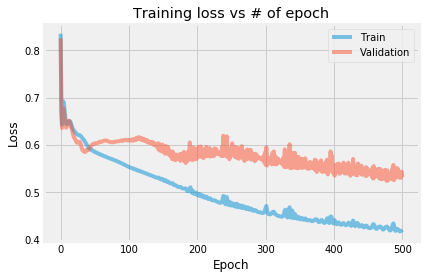

In [526]:
# Plot loss
plt.plot(history, alpha=.5, label='Train')
plt.plot(history_valid, alpha=.5, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss vs # of epoch')
plt.show()